In [1]:
import cloudberry.api as cb

In [2]:
# Define Cloudberry configuration
cb_port = 9000
cb_config = cb.CloudberryConfig(f'http://localhost:{cb_port}')

# Initialize selected API(s)
cb_data = cb.Data(cb_config)
cb_analytics = cb.Analytics(cb_config)
cb_anomalies = cb.Anomalies(cb_config)
cb_buckets = cb.Buckets(cb_config)
cb_meta = cb.Metadata(cb_config)
cb_meta_experiment = cb_meta.experiment_api()
cb_meta_experiment_configuration = cb_meta.experiment_configuration_api()
cb_meta_experiment_computation = cb_meta.experiment_computation_api()
cb_query = cb.Query(cb_config)
cb_uploader = cb.AgeFileUploader(cb_config)
cb_csv_uploader = cb.CsvFileUploader(cb_config)
cb_api_configuration = cb.ApiConfiguration(cb_config)
cb_deleteion = cb.Deletion(cb_config)

In [3]:
# cb.Data

import math
import datetime

get_current_timestamp = lambda: math.trunc(datetime.datetime.utcnow().timestamp())

current_time = get_current_timestamp()
data_points = [
    cb.DataPoint(time=current_time, fields={'version': 0.1}, tags={'origin': 'jupyter_notebook', 'type': 'api_demo'}),
    cb.DataPoint(time=current_time + 1, fields={'version': 0.2}, tags={'origin': 'jupyter_notebook', 'type': 'api_demo'}),
    cb.DataPoint(time=current_time + 2, fields={'version': 0.1}, tags={'origin': 'notebook', 'type': 'api_demo'}),
    cb.DataPoint(time=current_time + 3, fields={'version': 0.2}, tags={'origin': 'notebook', 'type': 'api_demo'}),
]

# Save data points explicitly
result = cb_data.save_data(data_points)
print(result)

# Get those data points with filters
result = cb_data.get_data(cb.DataFilters(tags={'origin': 'notebook'}))
print(len(result.data))

result = cb_data.get_data(cb.DataFilters(fields={'version': 0.1}))
print(len(result.data))

result = cb_data.get_data(cb.DataFilters(tags={'origin': 'notebook'}, fields={'version': 0.1}))
print(len(result.data), result.data)


# *New* - get points by tags presence, ignoring the value

result = cb_data.get_data(cb.DataFilters(tags_presence=['origin']))
print(len(result.data))

result = cb_data.get_data(cb.DataFilters(tags_presence=['origin', 'halo']))
print(len(result.data))


# Delete data points
result = cb_data.get_data(cb.DataFilters(tags={'type': 'api_demo'}))
print('before: ', len(result.data))

result = cb_data.delete_data(cb.DataFilters(tags={'type': 'api_demo'}))
print(result)

result = cb_data.get_data(cb.DataFilters(tags={'type': 'api_demo'}))
print('after: ', len(result.data))

True
2
2
1 [{'_time': 1602784900.0, '_measurement': 'cloudberry-default', 'origin': 'notebook', 'type': 'api_demo', 'version': 0.1}]
4
0
before:  4
True
after:  0


In [4]:
# cb.Buckets

buckets_names = cb_buckets.get_buckets_names()
print(buckets_names)

result = cb_buckets.create_bucket('wiadro_0')
print(result)

buckets_names = cb_buckets.get_buckets_names()
print(buckets_names)

result = cb_buckets.delete_bucket('wiadro_0')
print(result)

buckets_names = cb_buckets.get_buckets_names()
print(buckets_names)

['_monitoring', 'cloudberry_logs', '_tasks']
True
['_monitoring', 'cloudberry_logs', '_tasks', 'wiadro_0']
True
['_monitoring', 'cloudberry_logs', '_tasks']


In [5]:
# cb.Query

result = cb_query.query_series("""
from(bucket:"cloudberry_logs")
|> range(start: 0)
|> filter(fn: (r) => r._field == "AVERAGE_FITNESS")
|> keep(columns: ["_value", "_time"])
""")

result.as_data_frame

,result,table,_time,_value,series_name
0,_result,0,5.013092e+06,4.577046,"\nfrom(bucket:""cloudberry_logs"")\n|> range(sta..."
1,_result,0,1.000213e+07,4.574657,"\nfrom(bucket:""cloudberry_logs"")\n|> range(sta..."
2,_result,0,1.501414e+07,4.601292,"\nfrom(bucket:""cloudberry_logs"")\n|> range(sta..."
3,_result,0,2.000951e+07,4.638684,"\nfrom(bucket:""cloudberry_logs"")\n|> range(sta..."
4,_result,0,2.500768e+07,4.612407,"\nfrom(bucket:""cloudberry_logs"")\n|> range(sta..."
...,...,...,...,...,...
4074,_result,0,1.175009e+09,4.592791,"\nfrom(bucket:""cloudberry_logs"")\n|> range(sta..."
4075,_result,0,1.180010e+09,4.578759,"\nfrom(bucket:""cloudberry_logs"")\n|> range(sta..."
4076,_result,0,1.185009e+09,4.631339,"\nfrom(bucket:""cloudberry_logs"")\n|> range(sta..."
4077,_result,0,1.190006e+09,4.567330,"\nfrom(bucket:""cloudberry_logs"")\n|> range(sta..."


In [8]:
# cb.AgeFileUploader

computation_ids = []

age_log_file_path = './data/emas-20190412T120536.log'
age_log_experiment_name = 'EMAS_AGE'
age_log_headers_keys = {
    "[WH]": "[W]",
    "[SH]": "[S]",
    "[BH]": "[B]"
}

computation_id = cb_uploader.upload_file(
    file_path=age_log_file_path,
    experiment_name=age_log_experiment_name,
    details=cb.AgeUploadDetails(headers_keys=age_log_headers_keys)
)
computation_ids.append(computation_id)

In [12]:
# cb.Analytics

# Upload more data to Cloudberry
emas_files = [
    "./data/emas-20190411T232808.log",
    "./data/emas-20190411T234810.log",
    "./data/emas-20190412T000813.log",
    "./data/emas-20190412T120536.log",
]
for emas_file in emas_files:
    computation_id = cb_uploader.upload_file(
             file_path=emas_file,
             experiment_name=age_log_experiment_name,
             details=cb.AgeUploadDetails(headers_keys=age_log_headers_keys)
         )
    computation_ids.append(computation_id)

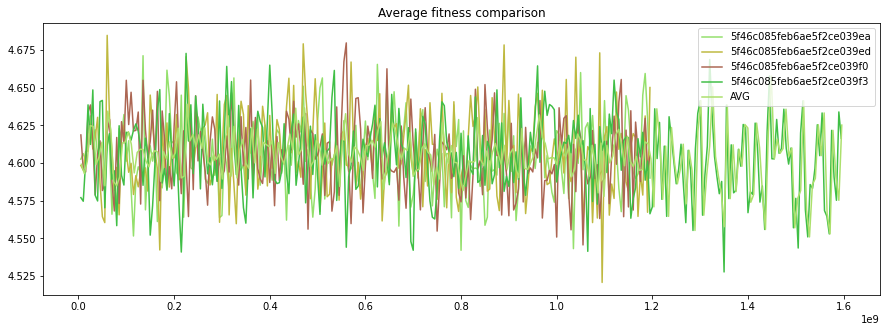

In [11]:
best_fitness_field = 'BEST_SOLUTION_SO_FAR'
fitness_field = 'AVERAGE_FITNESS'

# Use case 1. Compare multiple computations by their ids

series = cb_analytics.compare_computations(
    computation_ids=computation_ids,
    field_name=fitness_field
)

cb.DataSeriesPlots.compare(series=series, 
                           x_field='_time', 
                           y_field=fitness_field,
                           title='Average fitness comparison')

In [9]:
series[0].as_data_frame

,_time,_measurement,computationId,AVERAGE_FITNESS,series_name
0,5.013092e+06,cloudberry-default,5f8ca318aa78f91e4fd5cba6,4.577046,5f8ca318aa78f91e4fd5cba6
1,1.000213e+07,cloudberry-default,5f8ca318aa78f91e4fd5cba6,4.574657,5f8ca318aa78f91e4fd5cba6
2,1.501414e+07,cloudberry-default,5f8ca318aa78f91e4fd5cba6,4.601292,5f8ca318aa78f91e4fd5cba6
3,2.000951e+07,cloudberry-default,5f8ca318aa78f91e4fd5cba6,4.638684,5f8ca318aa78f91e4fd5cba6
4,2.500768e+07,cloudberry-default,5f8ca318aa78f91e4fd5cba6,4.612407,5f8ca318aa78f91e4fd5cba6
...,...,...,...,...,...
315,1.580002e+09,cloudberry-default,5f8ca318aa78f91e4fd5cba6,4.590729,5f8ca318aa78f91e4fd5cba6
316,1.585002e+09,cloudberry-default,5f8ca318aa78f91e4fd5cba6,4.575268,5f8ca318aa78f91e4fd5cba6
317,1.590006e+09,cloudberry-default,5f8ca318aa78f91e4fd5cba6,4.633988,5f8ca318aa78f91e4fd5cba6
318,1.595004e+09,cloudberry-default,5f8ca318aa78f91e4fd5cba6,4.616511,5f8ca318aa78f91e4fd5cba6


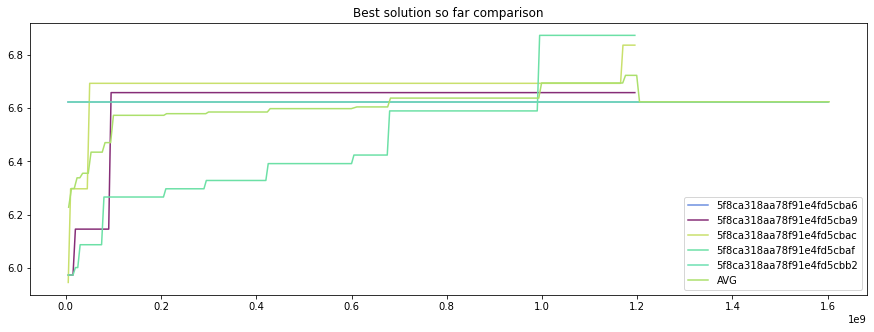

In [10]:
series = cb_analytics.compare_computations(
    computation_ids=computation_ids,
    field_name=best_fitness_field
)

cb.DataSeriesPlots.compare(series=series, 
                           x_field='_time', 
                           y_field=best_fitness_field,
                           title='Best solution so far comparison')

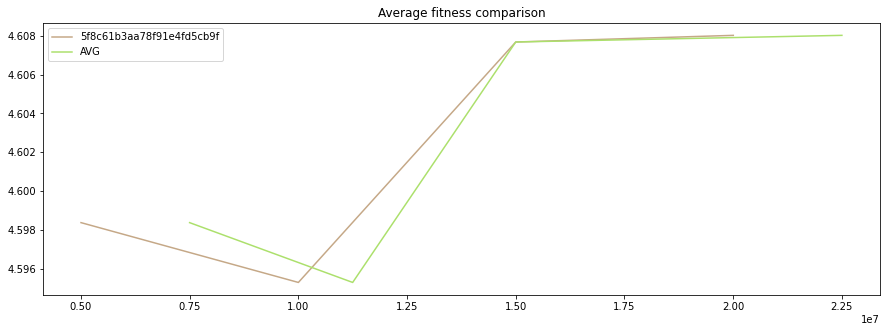

In [11]:
CONFIGURATION_ID = '5f8c29fe253b377dd231751c'

# Use case 2. Compare all computations for given configuration id

series = cb_analytics.compare_computations_for_configuration(
    configuration_id=CONFIGURATION_ID,
    field_name=fitness_field
)


cb.DataSeriesPlots.compare(series=series, 
                           x_field='_time', 
                           y_field=fitness_field,
                           title='Average fitness comparison')

In [12]:
# Another feature: append data from CSV
# - must specify configuration ID explicitly as CSV does not contain experiment configuration

age_csv_file_path = './data/emas_1.csv'

cb_csv_uploader.upload_file(
    file_path=age_csv_file_path,
    experiment_name=age_log_experiment_name,
    details=cb.CsvUploadDetails(
        tags_names=['WORKPLACE_ID'],
        configuration_id=CONFIGURATION_ID,
        computation_id=None # None for new computation
    )
)

'5f8ca31aaa78f91e4fd5cbb3'

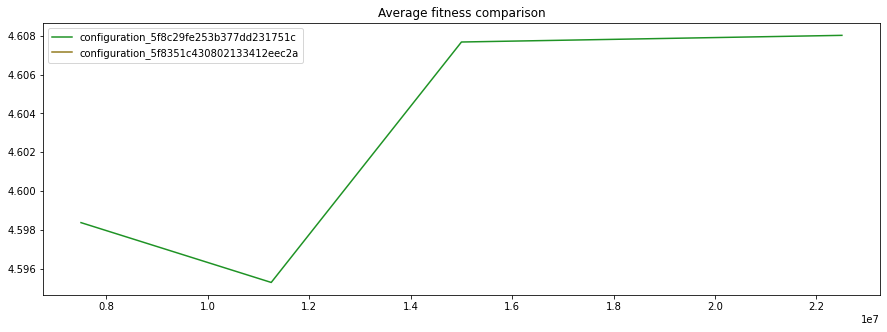

In [13]:
configuration_ids = [
    CONFIGURATION_ID,
    '5f8351c430802133412eec2a'
]

# Use case 3. Compare N configurations

series = cb_analytics.compare_configurations(
    configuration_ids=configuration_ids,
    field_name=fitness_field
)

cb.DataSeriesPlots.compare(series=series, 
                           x_field='_time', 
                           y_field=fitness_field,
                           title='Average fitness comparison')

In [4]:
# Use case 4. Compare all configurations for experiment

series = cb_analytics.compare_configurations_for_experiment(
    experiment_name=age_log_experiment_name,
    field_name=fitness_field
)

cb.DataSeriesPlots.compare(series=series, 
                           x_field='_time', 
                           y_field=fitness_field,
                           title='Average fitness comparison')

NameError: name 'age_log_experiment_name' is not defined

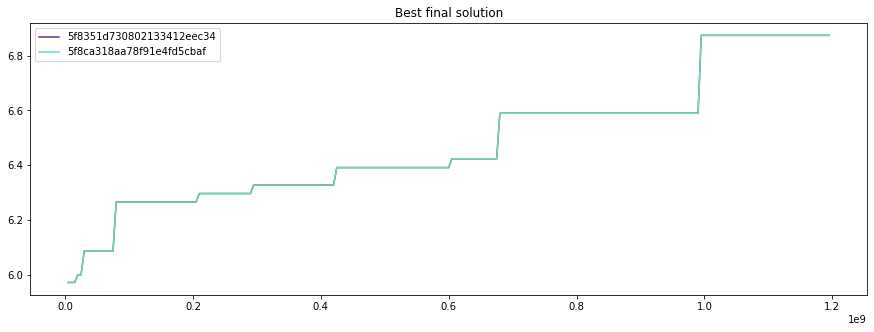

In [15]:
# Use case 5.1 Get best computations (optimization) by their final values

series = cb_analytics.best_n_computations(
    n=2,
    field_name='BEST_SOLUTION_SO_FAR',
    goal=cb.OptimizationGoal.MAX,
    kind=cb.OptimizationKind.FINAL_VALUE
)

cb.DataSeriesPlots.compare(series=series,
                           x_field='_time',
                           y_field='BEST_SOLUTION_SO_FAR',
                           title='Best final solution')


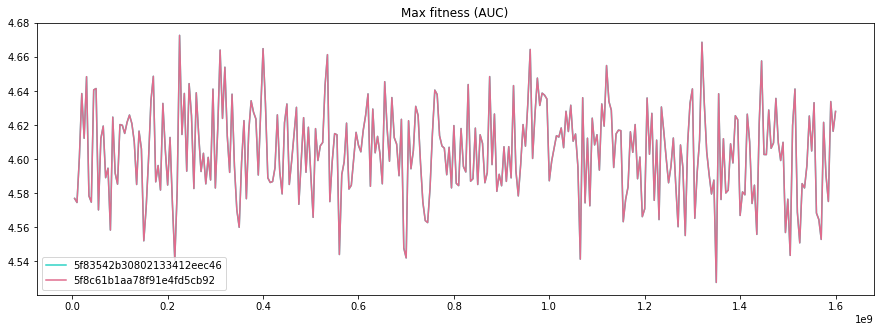

In [16]:
# Use case 5.2 Get best computations (optimization) by convergence (area under curve / integral)

series = cb_analytics.best_n_computations(
    n=2,
    field_name='AVERAGE_FITNESS',
    goal=cb.OptimizationGoal.MAX,
    kind=cb.OptimizationKind.AREA_UNDER_CURVE
)

cb.DataSeriesPlots.compare(series=series,
                           x_field='_time',
                           y_field='AVERAGE_FITNESS',
                           title='Max fitness (AUC)')


In [17]:
# Get mean and stddev for given computations
field_name = 'AVERAGE_FITNESS'


series = cb_analytics.avg_and_stddev_for_computations(
    computation_ids=computation_ids,
    field_name=field_name,
    interval=10,
    time_unit=cb.TimeUnit.DAYS,
)

In [18]:
series.as_data_frame

,_time,AVG,STDDEV,series_name
0,5.184000e+06,4.594759,0.0178561,AVERAGE_FITNESS
1,1.036800e+07,4.589367,0.0141239,AVERAGE_FITNESS
2,1.555200e+07,4.601288,0.00480637,AVERAGE_FITNESS
3,2.073600e+07,4.627656,0.013543,AVERAGE_FITNESS
4,2.505600e+07,4.624154,0.0116279,AVERAGE_FITNESS
...,...,...,...,...
317,1.580256e+09,4.590729,0,AVERAGE_FITNESS
318,1.585440e+09,4.575268,0,AVERAGE_FITNESS
319,1.590624e+09,4.633988,0,AVERAGE_FITNESS
320,1.595808e+09,4.616511,0,AVERAGE_FITNESS


In [ ]:
cb.DataSeriesPlots.compare(series=[series],
                           x_field='_time',
                           y_field='AVG',
                           yerr_field='STDDEV',
                           title='Average + Standard Deviation')

5f83543630802133412eec47


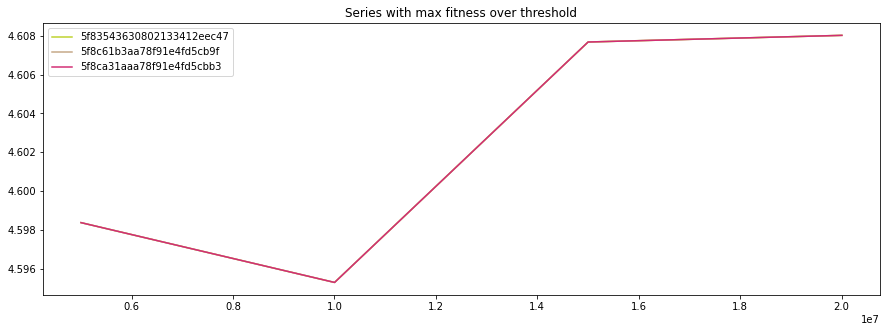

In [20]:
# (Issue #40) Use case 6.1. get computations that values has reached given thresholds (either over or under)
# Criteria mode can be one of the following: ANY, AVERAGE, FINAL

series = cb_analytics.thresholds_exceeding_computations(
    field_name='AVERAGE_FITNESS',
    criteria_mode=cb.CriteriaMode.AVERAGE,
    thresholds=cb.Thresholds(lower=4.6045)
)

print(series[0].series_name)

cb.DataSeriesPlots.compare(series=series,
                           x_field='_time',
                           y_field='AVERAGE_FITNESS',
                           title='Series with max fitness over threshold')

In [9]:
# Use case 6.2. analyze computations for possible anomalies.

reports = cb_anomalies.get_reports(
    field_name='AVERAGE_FITNESS',
    computation_ids=computation_ids
)

print(reports[0].__dict__)

[None, None, None, None, None]


In [22]:
# crud metadata

In [23]:
# experiment

In [24]:
created_experiment = cb_meta_experiment.find_or_create('experiment name', parameters={'important': 'very'})
print(created_experiment)
created_experiment_id = created_experiment['id']

{'id': '5f8ca37caa78f91e4fd5cbb5', 'name': 'experiment name', 'parameters': {'important': 'very'}, 'time': 1603052412.3931968}


In [25]:
new_name = 'updated namee'
cb_meta_experiment.update(experiment_id=created_experiment_id, name=new_name, parameters={'color': 'red'}, override_params = False)

{'id': '5f8ca37caa78f91e4fd5cbb5',
 'name': 'updated namee',
 'parameters': {'important': 'very', 'color': 'red'},
 'time': 1603052412.393}

In [26]:
cb_meta_experiment.find_all()

[{'id': '5f8c39a62bfcd81a59159e54',
  'name': 'updated namee',
  'parameters': {'important': 'very', 'color': 'red'},
  'time': 1603025318.651},
 {'id': '5f8c61b1aa78f91e4fd5cb90',
  'name': 'EMAS_AGE',
  'parameters': {},
  'time': 1603035569.827},
 {'id': '5f8c61c2aa78f91e4fd5cba1',
  'name': 'updated namee',
  'parameters': {'important': 'very', 'color': 'red'},
  'time': 1603035586.015},
 {'id': '5f8ca37caa78f91e4fd5cbb5',
  'name': 'updated namee',
  'parameters': {'important': 'very', 'color': 'red'},
  'time': 1603052412.393}]

In [27]:
cb_meta_experiment.find_by_name(new_name)

[{'id': '5f8c39a62bfcd81a59159e54',
  'name': 'updated namee',
  'parameters': {'important': 'very', 'color': 'red'},
  'time': 1603025318.651},
 {'id': '5f8c61c2aa78f91e4fd5cba1',
  'name': 'updated namee',
  'parameters': {'important': 'very', 'color': 'red'},
  'time': 1603035586.015},
 {'id': '5f8ca37caa78f91e4fd5cbb5',
  'name': 'updated namee',
  'parameters': {'important': 'very', 'color': 'red'},
  'time': 1603052412.393}]

In [28]:
# experiment configuration

In [29]:
configuration_file_name = "configuration file name"
created_configuration = cb_meta_experiment_configuration.find_or_create(created_experiment_id, configuration_file_name, {"param1": "value"})
print(created_configuration)
created_configuration_id = created_configuration['id']

{'id': '5f8ca37caa78f91e4fd5cbb6', 'experimentId': '5f8ca37caa78f91e4fd5cbb5', 'configurationFileName': 'configuration file name', 'parameters': {'param1': 'value'}, 'time': 1603052412.5451958}


In [30]:
cb_meta_experiment_configuration.find_by_configuration_file_name(configuration_file_name)

[{'id': '5f8ca37caa78f91e4fd5cbb6',
  'experimentId': '5f8ca37caa78f91e4fd5cbb5',
  'configurationFileName': 'configuration file name',
  'parameters': {'param1': 'value'},
  'time': 1603052412.545}]

In [31]:
cb_meta_experiment_configuration.find_by_experiment_name(new_name)

[{'id': '5f8c39a62bfcd81a59159e55',
  'experimentId': '5f8c39a62bfcd81a59159e54',
  'configurationFileName': 'new config file name',
  'parameters': {'additionalParam': True, 'param1': 'value'},
  'time': 1603025318.759},
 {'id': '5f8c61c2aa78f91e4fd5cba2',
  'experimentId': '5f8c61c2aa78f91e4fd5cba1',
  'configurationFileName': 'new config file name',
  'parameters': {'additionalParam': True, 'param1': 'value'},
  'time': 1603035586.137},
 {'id': '5f8ca37caa78f91e4fd5cbb6',
  'experimentId': '5f8ca37caa78f91e4fd5cbb5',
  'configurationFileName': 'configuration file name',
  'parameters': {'param1': 'value'},
  'time': 1603052412.545}]

In [32]:
new_file_name="new config file name"
cb_meta_experiment_configuration.update(configuration_id=created_configuration_id, configuration_file_name=new_file_name, parameters={"additionalParam": True}, override_params=False)

{'id': '5f8ca37caa78f91e4fd5cbb6',
 'experimentId': '5f8ca37caa78f91e4fd5cbb5',
 'configurationFileName': 'new config file name',
 'parameters': {'additionalParam': True, 'param1': 'value'},
 'time': 1603052412.545}

In [33]:
# experiment computation

In [34]:
cb_meta_experiment_computation.create(created_configuration_id)

{'id': '5f8ca37caa78f91e4fd5cbb7',
 'configurationId': '5f8ca37caa78f91e4fd5cbb6',
 'time': 1603052412.6832004}

In [35]:
cb_meta_experiment_computation.find_by_configuration_id(created_configuration_id)

[{'id': '5f8ca37caa78f91e4fd5cbb7',
  'configurationId': '5f8ca37caa78f91e4fd5cbb6',
  'time': 1603052412.683}]

In [36]:
# (#47) - ApiConfiguration API

property_key = cb.ApiPropertiesIndex.OVERRIDDEN_DEFAULT_BUCKET_NAME

cb_api_configuration.set_property(property_key, "cloudberry_logs2")
property_value = cb_api_configuration.get_property(property_key)
print(property_value)

cb_api_configuration.delete_property(property_key)

property_value = cb_api_configuration.get_property(property_key)
print(property_value)


"cloudberry_logs2"



In [37]:
# delete all data

In [38]:
some_comp_id = cb_meta_experiment_computation.find_all()[0]['id']
cb_deleteion.delete_computations([some_comp_id])

In [39]:
some_config_id = cb_meta_experiment_configuration.find_all()[0]['id']
cb_deleteion.delete_computations([some_config_id])

In [40]:
some_exp_id = cb_meta_experiment.find_all()[0]['id']
cb_deleteion.delete_experiments([some_exp_id])

In [3]:
str(cb_meta_experiment.find_all()[0])

'Experiment(experiment_id_hex=5f88aaaac5b9954a47193621, name=EMAS_AGE, parameters={}, time=1602792106.534)'

In [41]:
configs = [
    "5f8c29fe253b377dd231751c",
    "5f8c2a01253b377dd231751f",
    "5f8c2aee253b377dd231753e"
]

best_configurations = cb_analytics.best_n_configurations(
    2,
    'BEST_SOLUTION_SO_FAR',
    configs,
    cb.OptimizationGoal.MIN,
    cb.OptimizationKind.AREA_UNDER_CURVE
)

In [42]:
# THRESHOLDS PER CONFIGURATION - compute mean series for CONGIFURATION and check if overally it exceeds given threshold(s)
field = 'AVERAGE_FITNESS'
series = cb_analytics.thresholds_exceeding_configurations(
    field_name=field,
    criteria_mode=cb.CriteriaMode.FINAL,
    thresholds=cb.Thresholds(upper=4.6),
    configuration_ids=configs
)

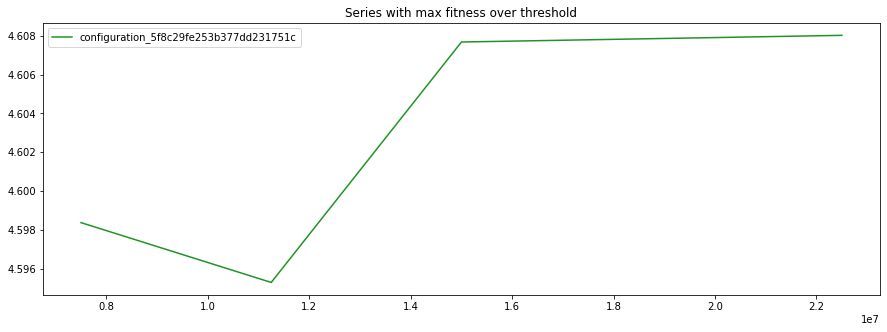

In [43]:
cb.DataSeriesPlots.compare(series=series,
                           x_field='_time',
                           y_field=field,
                           title='Series with max fitness over threshold')